In [1]:
import os
import sys
sys.path.append(os.getcwd() + '/src')
import numpy as np
import matplotlib.pyplot as plt
from utils import load, make_ref, make_inv_ref, get_clpoles, step_info, load_square_traj, load_8_traj, load_circle_J_traj
from simulation import Simulation, sim_closed_loop, trajectory_sim
import system_data as sysdat
from system_data import Ad, Bd, Cd, Dd
from vis_data import triple_plot, triple_plot2, plot_poles, scatter_controllers, plot_pose
from project import project, Controller
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

### How did the solver perform? 

In [3]:
all_controllers = load('data/controllers_solver-SCS_all.pkl')
print('Number of projects:', len(all_controllers))

Number of projects: 190


status
infeasible_inaccurate      9
optimal                  102
optimal_inaccurate        79
Name: status, dtype: int64


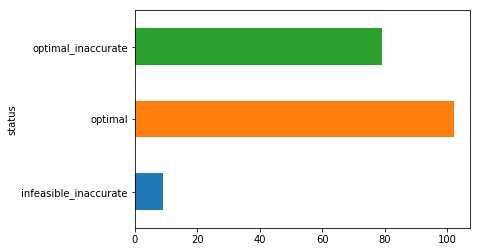

In [4]:
df = pd.DataFrame({'status': [c.status for c in all_controllers]})
df_g = df.groupby('status')['status'].count()
print(df_g)
df_g.plot.barh()

### How good is a controller that has poles freely alocated on the unit circle? 

In [5]:
q = 0.0
r = 0.99999
K, baseline_norm, P, status = project(Ad, Bd, Cd, Dd, q, r)

print('Optimization status:', status)
print('Minimal Hinf norm %.2f' % baseline_norm)


Optimization status: optimal
Minimal Hinf norm 17.70


[-0.17462077  0.20302415  0.20302416  0.53997562  0.91718341  0.91718341]


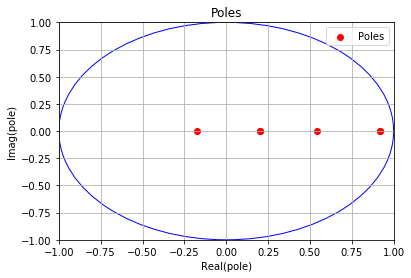

In [6]:
poles = get_clpoles(Ad, Bd, K)
plot_poles(poles, q, r)
print(poles)

How is its transitory response?

In [7]:
ref = make_inv_ref([0.6, 0, 0], [-0.6,0,0], 100)
states, control_signal, time = sim_closed_loop(ref, Simulation(sysdat.csys, sysdat.Ts), K)
baseline_info = step_info(time[:40], states[:40, 0])

baseline_u_max_var = np.max(np.abs(control_signal[:-1, :] - control_signal[1:, :]))
print('Max. Control Signal Var:', baseline_u_max_var)

Max. Control Signal Var: 11.526401171129685


RiseTime: 0.300
SettlingTime: 1.140
Overshoot: 0.019
PeakTime: 2.340


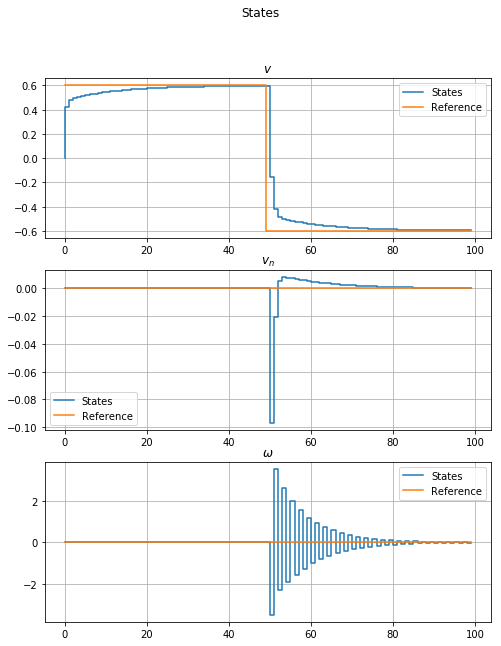

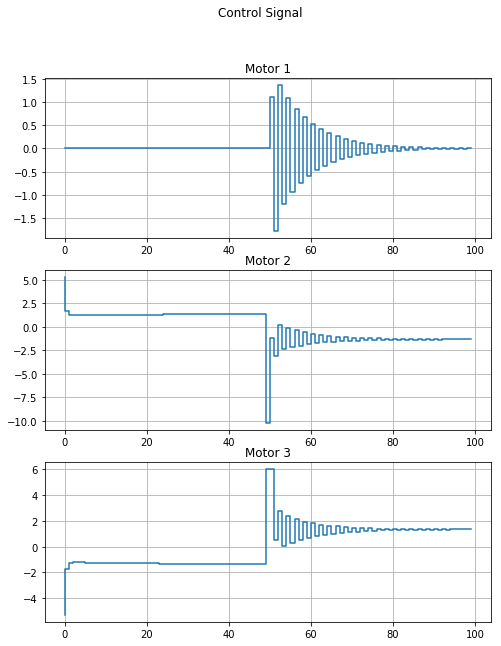

In [8]:
print(baseline_info)
triple_plot2(states, ref, 'States', 'Reference', figsize=(8, 10))
triple_plot(control_signal, 'Control Signal', figsize=(8, 10))

### Choosing a Controller
From controller data generated by running `project.py`

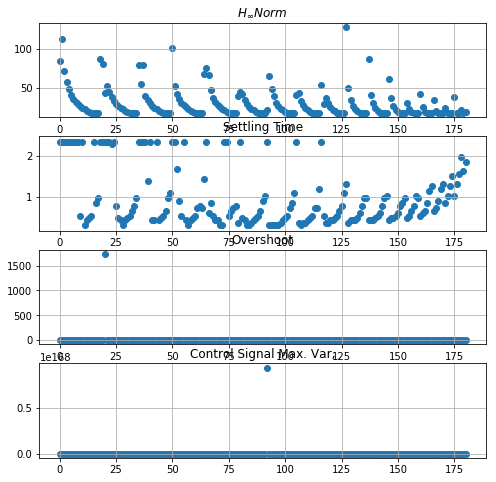

In [9]:
controllers = [c for c in all_controllers if not c.poles is None]

st = np.array([c.stepinfo.SettlingTime for c in controllers])
os = np.array([c.stepinfo.Overshoot for c in controllers])
u_var = np.array([c.u_max_var for c in controllers])
norm = np.array([c.norm for c in controllers])

arrs = [norm, st, os, u_var]
titles = [r'$H_{\infty} Norm$', 'Settling Time', 'Overshoot', 'Control Signal Max. Var,']
scatter_controllers(arrs, titles)

Filtering:

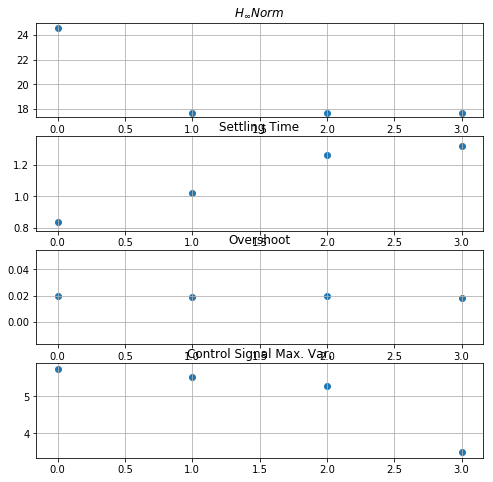

In [24]:
idx = np.where((st < 1.4) & (u_var < 6) & (norm < 25))[0]
filtered_arrs = [arr[idx] for arr in arrs]
scatter_controllers(filtered_arrs, titles)

Choosing the last controller

In [25]:
c = controllers[idx[-1]]
print(c)
print('Control Signal Max. Var.:', c.u_max_var)
print('Status:', c.status)

Center: 0.80
Radius: 0.10
Hinf Norm: 17.70
Status: optimal_inaccurate
Poles: [0.8608222  0.86082445 0.82258409 0.72820789 0.76172884 0.76173666]
Control Signal Max. Var.: 3.489807243406469
Status: optimal_inaccurate


In [12]:
K = c.K
print(c.K)

[[ 8.66614712e-05  2.87890344e+00  6.85112771e-02  1.28208414e-05
   4.79170724e-01 -1.93353126e-02]
 [-2.49326466e+00 -1.43954273e+00  6.45593377e-02 -4.14988259e-01
  -2.39601139e-01 -2.01532419e-02]
 [ 2.49319630e+00 -1.43941585e+00  6.84915149e-02  4.14970654e-01
  -2.39581856e-01 -1.93498843e-02]]


[0.8608222  0.86082445 0.82258409 0.72820789 0.76172884 0.76173666]


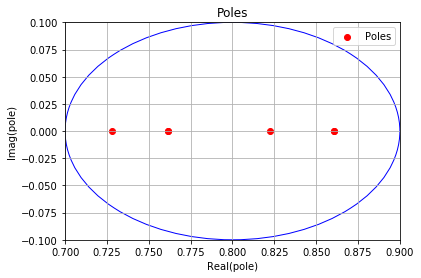

In [13]:
plot_poles(c.poles, c.q, c.r)
print(c.poles)

View response

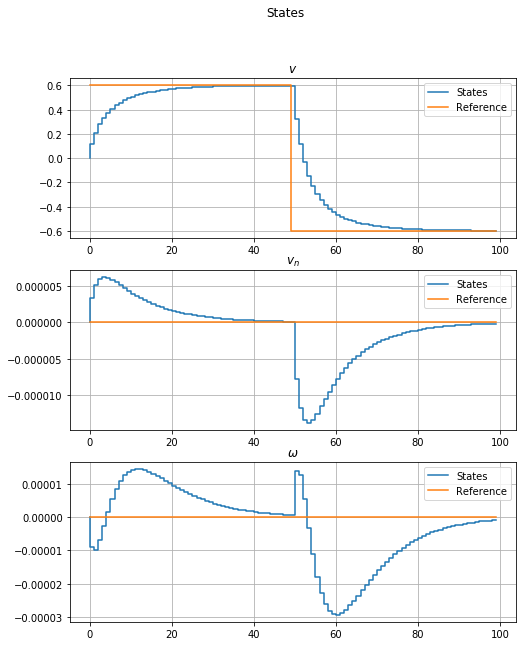

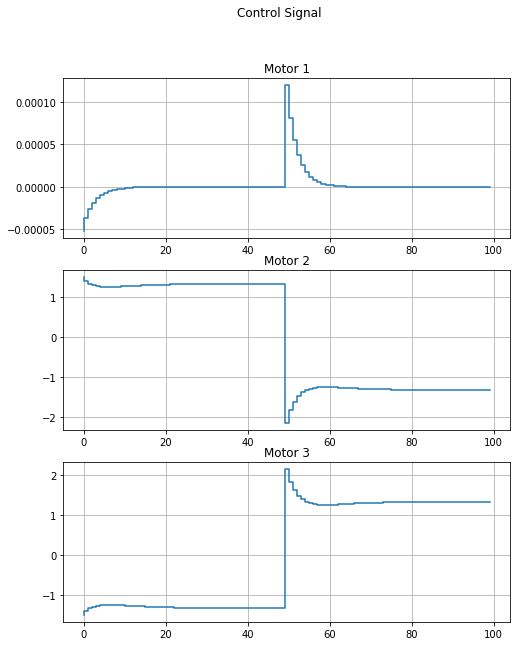

In [14]:
ref = make_inv_ref([0.6, 0, 0], [-0.6, 0, 0], 100)
states, control_signal, time = sim_closed_loop(ref, Simulation(sysdat.csys, sysdat.Ts), K)
triple_plot2(states, ref, 'States', 'Reference', figsize=(8, 10))
triple_plot(control_signal, 'Control Signal', figsize=(8, 10))

Compare with baseline controller

In [15]:
info_chosen = step_info(time[0:40], states[:40, 0])
print('Chosen controller performance:')
print(info_chosen)

Chosen controller performance:
RiseTime: 0.660
SettlingTime: 1.320
Overshoot: 0.018
PeakTime: 2.340


In [16]:
print('Baseline controller performance:')
print(baseline_info)

Baseline controller performance:
RiseTime: 0.300
SettlingTime: 1.140
Overshoot: 0.019
PeakTime: 2.340


In [17]:
print('Reduction in control signal max. variation: %.2f%%' % ((baseline_u_max_var - c.u_max_var)/baseline_u_max_var * 100))
print('Increase in the Hinf. norm: %.2f%%' % ((c.norm - baseline_norm  )/baseline_norm * 100))

Reduction in control signal max. variation: 69.72%
Increase in the Hinf. norm: -0.00%


### Simulation 1: v_nav = 0.3

Square trajectory:

In [18]:
v_nav = 0.3

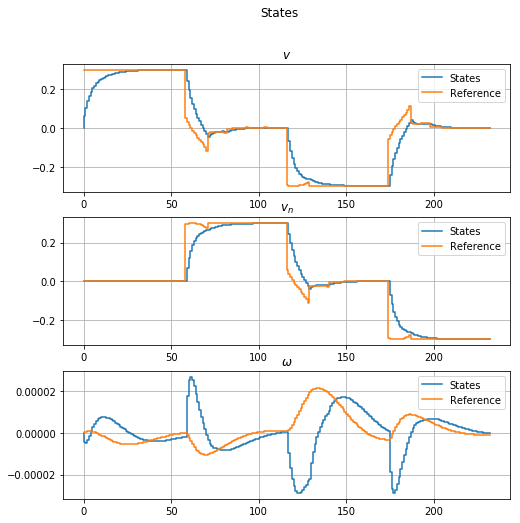

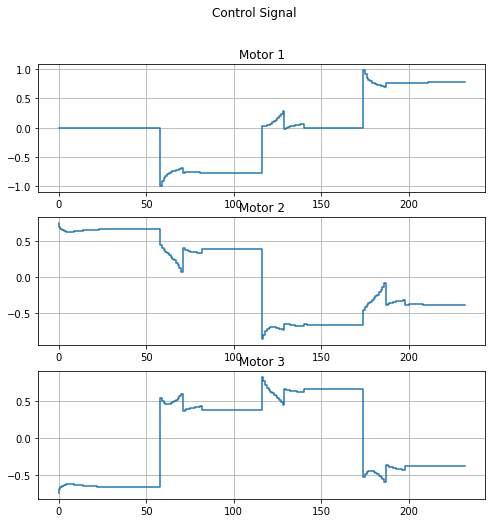

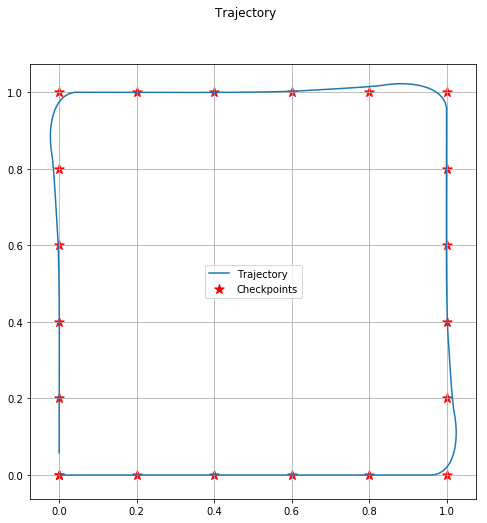

In [19]:
traj = load_square_traj()
states, control_signal, ref, pose = trajectory_sim(traj, v_nav, Simulation(sysdat.csys, sysdat.Ts), K)

triple_plot2(states, ref, 'States', 'Reference')
triple_plot(control_signal, 'Control Signal')
plot_pose(pose, load_square_traj())

Circle trajectory:

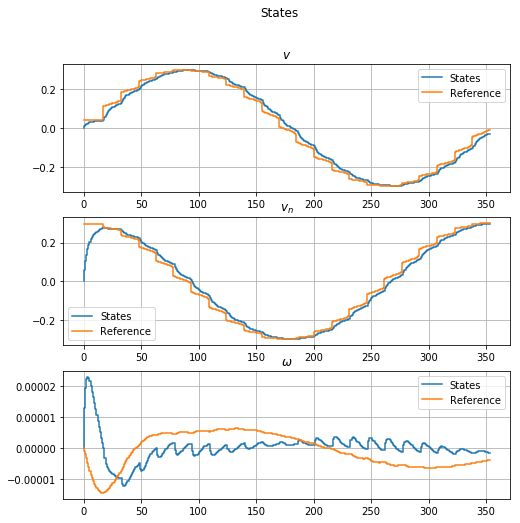

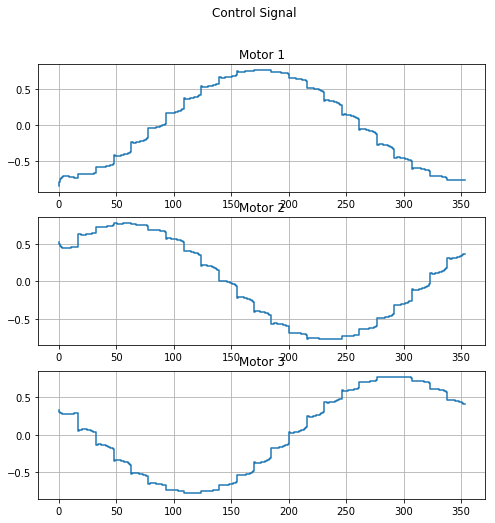

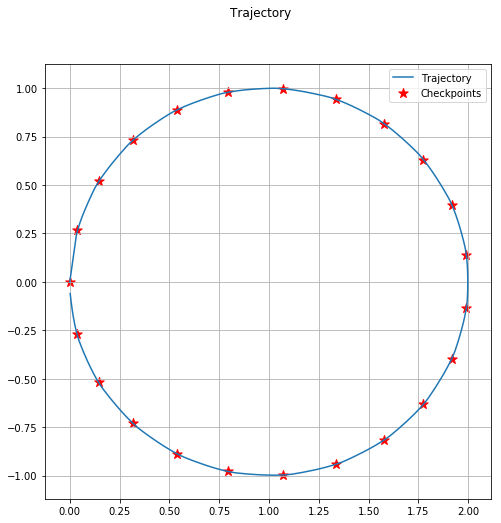

In [20]:
traj = load_circle_J_traj()
states, control_signal, ref, pose = trajectory_sim(traj, v_nav, Simulation(sysdat.csys, sysdat.Ts), K)

triple_plot2(states, ref, 'States', 'Reference')
triple_plot(control_signal, 'Control Signal')
plot_pose(pose, traj)

### Simulation 2: v_nav = 0.6

Square trajectory:

In [21]:
v_nav = 0.6

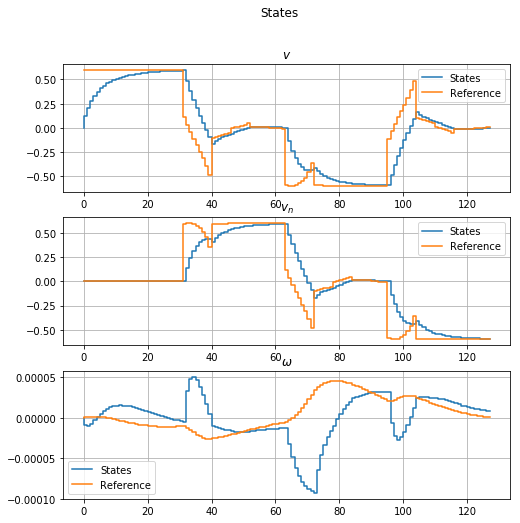

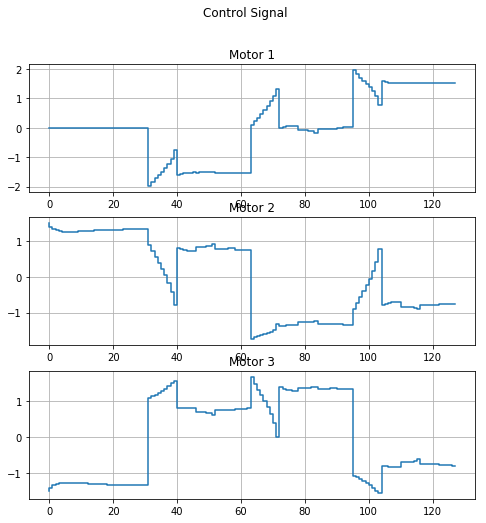

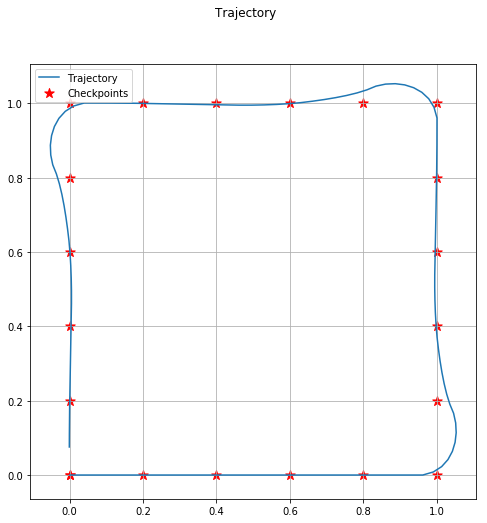

In [22]:
traj = load_square_traj()
states, control_signal, ref, pose = trajectory_sim(traj, v_nav, Simulation(sysdat.csys, sysdat.Ts), K)

triple_plot2(states, ref, 'States', 'Reference')
triple_plot(control_signal, 'Control Signal')
plot_pose(pose, load_square_traj())

Circle trajectory:

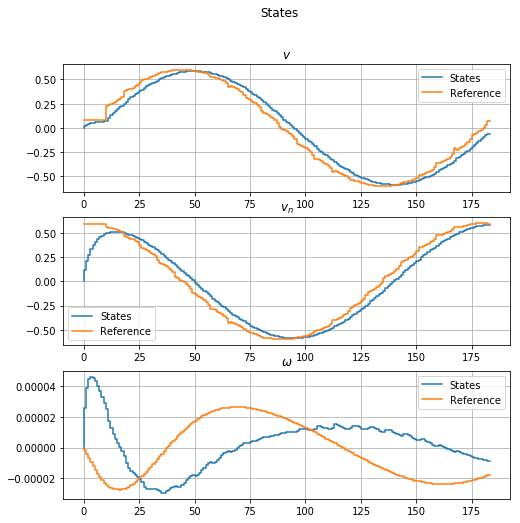

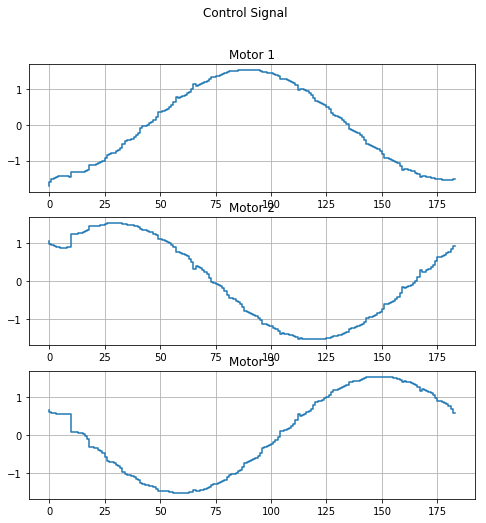

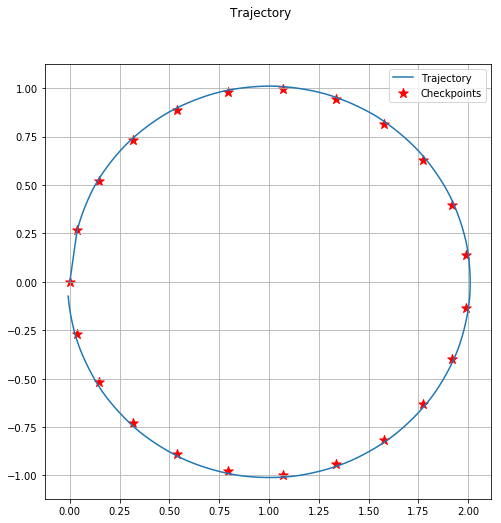

In [23]:
traj = load_circle_J_traj()
states, control_signal, ref, pose = trajectory_sim(traj, v_nav, Simulation(sysdat.csys, sysdat.Ts), K)

triple_plot2(states, ref, 'States', 'Reference')
triple_plot(control_signal, 'Control Signal')
plot_pose(pose, traj)